In [3]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf
import utils.data
from utils.layers import Encoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [16]:
data = utils.data.get_dataset(mode='mel')

In [9]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for i in range(len(data["mapping"])):
    data_length = data["labels"].count(i)
    start = data["labels"].index(i)
    train_size = int(train_ratio*data_length)
    valid_size = int(valid_ratio*data_length)
    test_size = int(test_ratio*data_length)

    for element in data["mfcc"][start:start+train_size]:
        X_train.append(element)
    for element in data["labels"][start:start+train_size]:
        Y_train.append(element)
    for element in data["mfcc"][start+train_size:start+train_size+valid_size]:
        X_valid.append(element)
    for element in data["labels"][start+train_size:start+train_size+valid_size]:
        Y_valid.append(element)
    for element in data["mfcc"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        X_test.append(element)
    for element in data["labels"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        Y_test.append(element)

In [10]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [11]:
X_train.shape

(6989, 130, 128)

In [12]:
X_train = tf.expand_dims(X_train, axis=-1)
X_valid = tf.expand_dims(X_valid, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

In [13]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

In [8]:
# Using the functional API to build a model
input = Input(shape=(X_train.shape[1:]))
conv1 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(input)
conv2 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(conv1)
# Pooling layer to reduce the dimensionality of the output (downsampling)
ap = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv2)
# Batch normalization to normalize the activations of the previous layer at each batch
ap = BatchNormalization()(ap)
conv3 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(ap)
ap = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv3)
ap = BatchNormalization()(ap)
conv4 = Conv2D(filters=128, kernel_size=4, activation='relu', padding='valid', kernel_initializer='glorot_normal')(ap)
# Global average pooling to reduce the dimensionality of the output (no parameters to learn)
ap = GlobalAveragePooling2D()(conv4)
dense1 = Dense(256, activation='relu')(ap)
dense1 = Dropout(0.1)(dense1)
dense2 = Dense(128, activation='relu')(dense1)
# Output layer with softmax activation
output = Dense(len(data["mapping"]), activation='softmax')(dense2)
conv_model = tf.keras.Model(inputs=input, outputs=output)


In [9]:
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 130, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 126, 256)     2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 124, 256)     590080    
                                                                 
 average_pooling2d (AverageP  (None, 63, 62, 256)      0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 63, 62, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 60, 256)       590080

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [11]:
conv_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
conv_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_valid, Y_valid), verbose=1, callbacks=es)

32/32 [==============================] - 2s 53ms/step
              precision    recall  f1-score   support

           0       0.58      0.38      0.46       100
           1       0.86      0.78      0.81        99
           2       0.56      0.75      0.64        99
           3       0.66      0.96      0.78        99
           4       0.84      0.91      0.87        99
           5       0.57      0.71      0.63        99
           6       0.82      0.60      0.69       100
           7       0.99      0.90      0.94       100
           8       0.74      0.78      0.76       100
           9       0.60      0.39      0.47       100

    accuracy                           0.71       995
   macro avg       0.72      0.72      0.71       995
weighted avg       0.72      0.71      0.71       995



[Text(0, 0.5, 'blues'),
 Text(0, 1.5, 'classical'),
 Text(0, 2.5, 'country'),
 Text(0, 3.5, 'disco'),
 Text(0, 4.5, 'hiphop'),
 Text(0, 5.5, 'jazz'),
 Text(0, 6.5, 'metal'),
 Text(0, 7.5, 'pop'),
 Text(0, 8.5, 'reggae'),
 Text(0, 9.5, 'rock')]

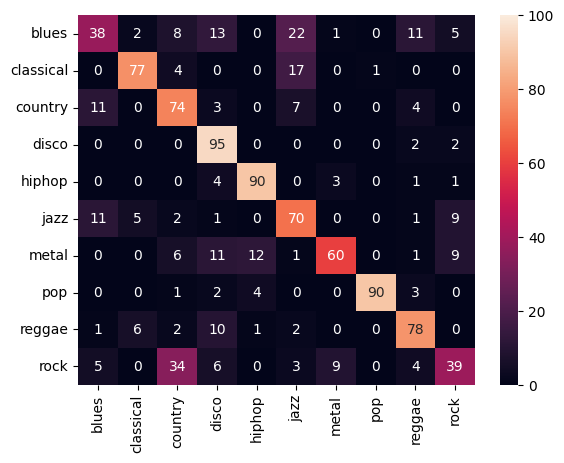

In [15]:
preds = conv_model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
dia= sns.heatmap(conf, annot=True, fmt='d', vmax=100)
dia.set_xticklabels(data["mapping"], rotation=90)
dia.set_yticklabels(data["mapping"], rotation=0)

In [ ]:
conv_model.save('./models/conv.h5')